# Mini-proyecto de Computer Vision (OpenCV): *lectura didáctica* de una matrícula UK (amarilla) sin OCR

> **Objetivo didáctico**: construir un pipeline que combine varias técnicas clásicas de CV, **sin pretender ser perfecto**, para:
1. Cargar una imagen (local o URL) con la **parte trasera de un coche** y una **matrícula UK amarilla**.
2. **Normalizar** valores (0–1) y **redimensionar** la imagen.
3. Usar **K-Means** sobre píxeles para quedarnos con la región **amarilla** (matrícula + ruido).
4. **Binarizar** y aplicar **morfología** (erode/dilate) para limpiar.
5. Localizar la **caja de la matrícula** con **proyecciones** (sumas por fila/columna).
6. Segmentar cada **carácter** con la misma idea (proyección vertical).
7. Reconocer cada carácter por **comparación con plantillas** (*template matching*).
8. Devolver la predicción final.

---

## ⚠️ Aviso importante (ético y práctico)
- Usa imágenes **propias** o con derechos adecuados (o datasets educativos).
- Este notebook es **para aprender** técnicas, no para desplegar un sistema robusto en producción.

---

## Requisitos
- `opencv-python`
- `numpy`
- `matplotlib`
- (opcional) `requests` para cargar desde URL

In [1]:
# Si estás en Colab / entorno limpio:
# !pip -q install opencv-python matplotlib requests

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Opcional para URLs
import requests
from io import BytesIO

In [2]:
# --- Configuración de entrada ---
USE_URL = True

# URL por defecto (Wikimedia Commons). Si falla, pon USE_URL=False y usa ruta local.
IMAGE_URL = "https://cdn.warrantywise.co.uk/wp-content/uploads/2020/09/03115906/The-New-70-Plate-Registration-Has-Launched-Cover-Photo.jpg.webp"
LOCAL_PATH = None

In [7]:
def load_image_bgr(use_url=True, image_url=None, local_path=None):
    """Carga una imagen en BGR (formato OpenCV), desde URL o disco."""
    if use_url:
        if not image_url:
            raise ValueError("Falta IMAGE_URL")
        r = requests.get(image_url, timeout=30)
        r.raise_for_status()
        img_arr = np.frombuffer(r.content, dtype=np.uint8)
        img = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError("No se pudo decodificar la imagen desde URL.")
        return img
    else:
        if not local_path:
            raise ValueError("Falta LOCAL_PATH")
        img = cv2.imread(local_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"No se pudo leer la imagen: {local_path}")
        return img

img_bgr = load_image_bgr(USE_URL, IMAGE_URL, LOCAL_PATH)

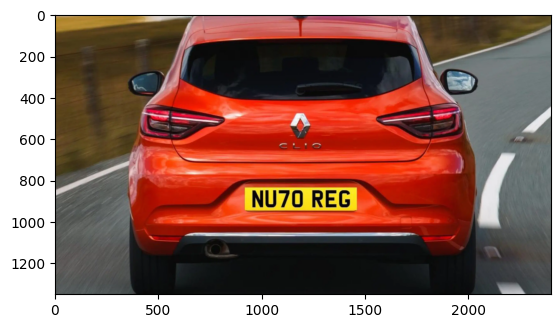

In [9]:
plt.imshow(img_bgr[:, :, [2,1,0]]);

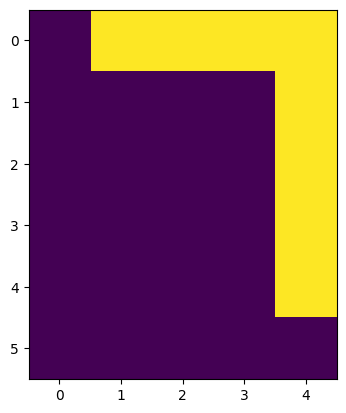

In [13]:
SEVEN = np.array([[0,1,1,1,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
ONE = np.array([[0,0,0,0,1], [0,0,0,1,1], [0,0,1,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
plt.imshow(SEVEN)


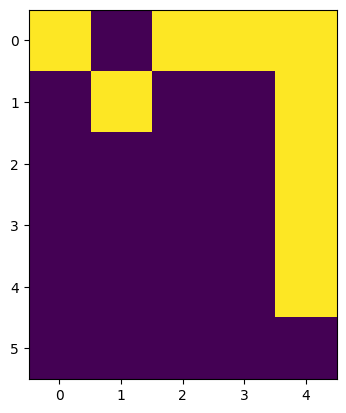

In [14]:
number = np.array([[1,0,1,1,1], [0,1,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
plt.imshow(number)

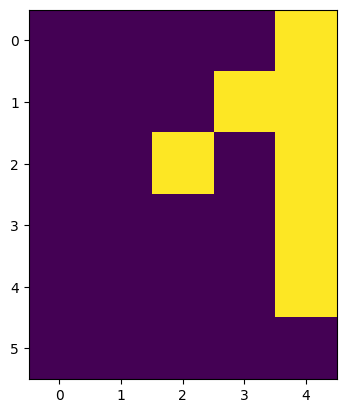

In [15]:
plt.imshow(ONE)

In [19]:
(number*SEVEN).sum()

np.int64(7)

In [18]:
(number * ONE).sum()

np.int64(5)

# TEMPLATES

In [ ]:
TEMPLATE_H = 45
TEMPLATE_W = 33

ALPHABET = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")

def make_template(char, w=TEMPLATE_W, h=TEMPLATE_H):
    img = np.zeros((h, w), dtype=np.uint8)
    # Fuente Hershey; probamos una combinación que suele verse "placa"
    font = cv2.FONT_HERSHEY_SIMPLEX  
    scale = 1.8
    thickness = 5

    # Centramos el texto
    (tw, th), baseline = cv2.getTextSize(char, font, scale, thickness)
    x = 2+(w - tw) // 2
    y = -2 + (h + th) // 2
    cv2.putText(img, char, (x, y), font, scale, 255, thickness, cv2.LINE_AA)

    # Opcional: pequeña dilatación para engordar un pelín
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    img = cv2.dilate(img, k, iterations=1)

    return img

templates = {ch: make_template(ch) for ch in ALPHABET}
